In [1]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u

import glob
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(6)
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms
from scipy import ndimage
from scipy.interpolate import LinearNDInterpolator

In [2]:
def TrainTest(dataset, md, cut, stop, value):
    
    hf = h5py.File(dataset, 'r')
    dataset_name = list(hf.keys())[0]
    images = np.array(hf.get(dataset_name))
    hf.close()
    X_train, X_test = images[0:cut], images[cut:stop]
    md_df = pd.read_csv(md)
    if 'OBJID_COPY' in md_df:
        md_df['OBJID'] = md_df['OBJID_COPY'].values
    md_train, md_test = md_df[0:cut], md_df[cut:stop]
    

    y_train, y_test = np.array([value] * len(X_train)), np.array([value] * len(X_test))
    
    return X_train, X_test, y_train, y_test, md_train, md_test

In [3]:
def gaussian2D(distance_to_center, sigma):
    return 1/(sigma**2*2*np.pi)*np.exp(-0.5*((distance_to_center)/sigma)**2)

In [4]:
def TemplateCenter(images, metadata):
    template_images = images[:,0,:,:]
    psfs = metadata['PSF'].values
    psf_in_px = psfs / 0.263
    psf_in_px = psfs[:,np.newaxis,np.newaxis] / 0.263 / 2.3548
    yy, xx = np.indices(template_images[0].shape)
    center_x, center_y = 25, 25
    distance_to_center = np.sqrt((yy - center_y)**2 + (xx - center_x)**2)[np.newaxis,:]
    distance_to_center = np.vstack(len(template_images)*[distance_to_center])
    psf_weights = gaussian2D(distance_to_center, psf_in_px)
    backgrounds = np.median(template_images, axis=(-1,-2))[:,np.newaxis,np.newaxis]
    center_fluxes = np.sum((template_images - backgrounds) * psf_weights, axis=(-1,-2))
    return center_fluxes

In [5]:
def SNR(metadata):
    metadata['SNR'] = metadata['FLUXCAL'].values/metadata['FLUXCALERR'].values
    return metadata['SNR'].values

In [6]:
def CatalogMatching(images, labels, metadata):
    # read in LightCurvesRealCoords.csv
    snid_coords = pd.read_csv('LightCurvesRealCoords.csv')
    # assume metadata is stored in "md_df"
    md_df = metadata.merge(snid_coords, on='SNID', how='inner')
    # Load in catalog
    catalog_df = pd.read_csv('DES_Star_Catalog_SOF.csv')
    # Use astropy
    catalog_coords = SkyCoord(ra= catalog_df['STAR_RA'].values*u.degree, dec= catalog_df['STAR_DEC'].values * u.degree)
    candidate_coords = SkyCoord(ra= md_df['RA'].values*u.degree, dec= md_df['DEC'].values * u.degree)
    idx, d2d, d3d = match_coordinates_sky(candidate_coords, catalog_coords)
    #https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html#astropy.coordinates.match_coordinates_sky
    # filter results
    threshold = 1 # in arcsec
    arc_sec_mask = (d2d > threshold * u.arcsec)
    md_indices = np.arange(len(md_df), dtype=int)
    keep_indices = md_indices[arc_sec_mask]
    md_objects_passing_catalog_match = md_df.loc[keep_indices]
    #apply to images
    return images[keep_indices], labels[keep_indices], md_objects_passing_catalog_match.reset_index(drop=True)

In [38]:
X_train0_0, X_test0_0, y_train0_0, y_test0_0, mdtrain0_0, mdtest0_0 = TrainTest('TS__2020-11-04_21-14-17/Class_0_images.h5','TS__2020-11-04_21-14-17/Class_0_metadata.csv',310,371,0)
X_train0_2, X_test0_2, y_train0_2, y_test0_2, mdtrain0_2, mdtest0_2 = TrainTest('Real__20-07-11_21-31-43/s200224ca_images.h5','Real__20-07-11_21-31-43/s200224ca_metadata.csv',180,214,0)

mdtrain0_2['ACTION'] = ['Good' for i in range(len(mdtrain0_2))]
mdtest0_2['ACTION'] = ['Good' for i in range(len(mdtest0_2))]

X_train0, X_test0 = np.concatenate((X_train0_0,X_train0_2)), np.concatenate((X_test0_0,X_test0_2))
y_train0, y_test0 = np.concatenate((y_train0_0,y_train0_2)), np.concatenate((y_test0_0,y_test0_2))
mdtrain0, mdtest0 = pd.concat([mdtrain0_0,mdtrain0_2]), pd.concat([mdtest0_0,mdtest0_2])
images_0 = np.concatenate((X_train0_0,X_train0_2,X_test0_0,X_test0_2))
md_0 = pd.concat([mdtrain0,mdtest0])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('TS__2020-11-04_21-14-17/Class_1_images.h5','TS__2020-11-04_21-14-17/Class_1_metadata.csv',100,400,0)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('TS__2020-11-04_21-14-17/Class_3_images.h5','TS__2020-11-04_21-14-17/Class_3_metadata.csv',2000,2800,1)
images_3 = np.concatenate((X_train3, X_test3))
md_3 = pd.concat([mdtrain3, mdtest3])
X_train3 = X_train3[0:1100]
y_train3 = np.array([1] * len(X_train3))
mdtrain3 = mdtrain3[0:1100]
#X_train3 = X_train3[mdtrain3.loc[mdtrain3.PHOTPROB < 0.4].index][0:1000]
#y_train3 = np.array([1] * len(X_train3))
#mdtrain3 = mdtrain3.loc[mdtrain3.PHOTPROB < 0.4][0:1000]

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('TS__2020-11-04_21-14-17/Class_4_images.h5','TS__2020-11-04_21-14-17/Class_4_metadata.csv',274,363,0)
images_4 = np.concatenate((X_train4, X_test4))
md_4 = pd.concat([mdtrain4, mdtest4])

X_train5, X_test5, y_train5, y_test5, mdtrain5, mdtest5 = TrainTest('TS__2020-11-04_21-14-17/Class_5_images.h5','TS__2020-11-04_21-14-17/Class_5_metadata.csv',274,368,0)
images_5 = np.concatenate((X_train5, X_test5))
md_5 = pd.concat([mdtrain5, mdtest5])

X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('TS__2020-11-04_21-14-17/Class_6_images.h5','TS__2020-11-04_21-14-17/Class_6_metadata.csv',762,1089,0)
images_6 = np.concatenate((X_train6, X_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [8]:
class0_centers = TemplateCenter(images_0,md_0)
class1_centers = TemplateCenter(images_1,md_1)
class3_centers = TemplateCenter(images_3,md_3)
class4_centers = TemplateCenter(images_4,md_4)
class5_centers = TemplateCenter(images_5,md_5)
class6_centers = TemplateCenter(images_6,md_6)
good_centers = np.concatenate((class0_centers, class1_centers, class3_centers, class6_centers))
notgood_centers = np.concatenate((class4_centers, class5_centers))
md_good = pd.concat([md_0, md_1, md_3, md_6], ignore_index=True)
md_notgood = pd.concat([md_4,md_5], ignore_index=True)
purity_centers, completeness_centers = [], []
thresholds = np.linspace(notgood_centers.min(), good_centers.max(), 100)
for threshold in thresholds:
    tp = np.sum(good_centers > threshold)
    fn = np.sum(good_centers < threshold)
    fp = np.sum(notgood_centers > threshold)
    purity_centers.append(tp / (tp + fp))
    completeness_centers.append(tp / (tp + fn))
desired_completeness = 0.99
center_thres = thresholds[np.argmin(np.abs(np.array(completeness_centers) - desired_completeness))]


thresgood_snr = SNR(md_good.loc[np.where(good_centers > center_thres)[0]])
thresbad_snr = SNR(md_notgood.loc[np.where(notgood_centers > center_thres)[0]])
purity_snr, completeness_snr = [], []
thresholds = np.linspace(thresbad_snr.min(), 20, 100)
for threshold in thresholds:
    tp = np.sum(thresgood_snr > threshold)
    fn = np.sum(thresgood_snr < threshold)
    fp = np.sum(thresbad_snr > threshold)
    purity_snr.append(tp / (tp + fp))
    completeness_snr.append(tp / (tp + fn))
desired_completeness = 0.99
snr_thres = thresholds[np.argmin(np.abs(np.array(completeness_snr) - desired_completeness))]

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [10]:
X_train, X_test = np.concatenate((X_train0,X_train3)), np.concatenate((X_test0,X_test3))
y_train, y_test = np.concatenate((y_train0,y_train3)), np.concatenate((y_test0,y_test3))
md_train, md_test = pd.concat([mdtrain0,mdtrain3], ignore_index=True), pd.concat([mdtest0,mdtest3], ignore_index=True)

In [11]:
train_centers = TemplateCenter(X_train, md_train)
test_centers = TemplateCenter(X_test, md_test)

train_snr = SNR(md_train.loc[np.where(train_centers > center_thres)[0]])
test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])

md_train_centers = md_train.loc[np.where(train_centers > center_thres)[0]].reset_index(drop=True)
md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)

md_train_filtered = md_train_centers.loc[np.where(train_snr > snr_thres)[0]]
md_test_filtered = md_test_centers.loc[np.where(test_snr > snr_thres)[0]]

train_remaining_indices = md_train[['OBJID']].merge(md_train_filtered, on='OBJID', how='inner', right_index=True).index
test_remaining_indices = md_test[['OBJID']].merge(md_test_filtered, on='OBJID', how='inner', right_index=True).index

X_train = X_train[train_remaining_indices]
X_test = X_test[test_remaining_indices]
y_train = y_train[train_remaining_indices]
y_test = y_test[test_remaining_indices]
md_train = md_train_filtered.reset_index(drop=True)
md_test = md_test_filtered.reset_index(drop=True)

X_train, y_train, md_train = CatalogMatching(X_train, y_train, md_train)
X_test, y_test, md_test = CatalogMatching(X_test, y_test, md_test)

In [12]:
X_train0_sims, X_test0_sims, y_train0_sims, y_test0_sims, mdtrain0_sims, mdtest0_sims = TrainTest('good_simulated_images.h5','good_simulated_metadata.csv',500,900,0)

In [13]:
X_train, X_test = np.concatenate((X_train,X_train0_sims)), np.concatenate((X_test,X_test0_sims))
y_train, y_test = np.concatenate((y_train,y_train0_sims,y_train1,y_train3)), np.concatenate((y_test,y_test0_sims))
md_train, md_test = pd.concat([md_train,mdtrain0_sims], ignore_index=True), pd.concat([md_test,mdtest0_sims], ignore_index=True)

In [14]:
print(len(md_train.loc[md_train['ACTION'] == 'Good']))
print(len(md_train.loc[md_train['ACTION'] == 'Marginal']))
print(len(md_train.loc[md_train['ACTION'] == 'BadSubtraction']))
print(len(md_train.loc[md_train['ACTION'] == 'NoisyTemplate']))
print(len(md_train.loc[md_train['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_train.loc[md_train['ACTION'] == 'PsfInTemplate']))

958
0
1091
0
0
0


In [15]:
train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]
md_train = md_train.iloc[train_idx].reset_index(drop=True)

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [16]:
del X_train0,X_train1,X_train3,X_train4,X_train6
del X_test0,X_test1,X_test3,X_test4,X_test6
del y_train0,y_train1,y_train3,y_train4,y_train6
del y_test0,y_test1,y_test3,y_test4,y_test6

In [17]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label = sample['image'], sample['label']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label)}

In [18]:
def make_datasets(X_train, y_train, X_test, y_test, batch_size=20):
    
    train_dataset = ArtifactDataset(X_train, y_train, transform=ToTensor())
    test_dataset = ArtifactDataset(X_test, y_test, transform=ToTensor())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_dataset, test_dataset, train_dataloader

In [19]:
train_dataset, test_dataset, train_dataloader = make_datasets(X_train, y_train, X_test, y_test)

In [20]:
train_size = 100
validation_size = 100
size_train = len(y_train)
size_test = len(y_test)
del X_train,X_test,y_train,y_test

In [21]:
class CNN_visualize(nn.Module):
    def __init__(self, init_weights=True):
        super(CNN_visualize, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=4, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=2, 
                               stride=1,
                               padding=2)

        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=128,
                               kernel_size=2, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=107648, 
                             out_features=328)
        
        self.fc2 = nn.Linear(in_features=328, 
                             out_features=18)
        
        self.fc3 = nn.Linear(in_features=18, 
                             out_features=2)
        
        # placeholder for the gradients
        self.gradients = None
        
        # Initialize all weights
        if init_weights:
            self._initialize_weights()
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        h = x.register_hook(self.activations_hook)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        
    def forward_to_hook(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=2)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.forward_to_hook(x)
    
    # weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
cnn = CNN_visualize()

In [22]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
number_of_training_epochs = 10

In [23]:
# Append some lists as we go to track the accuracies and loss
indices, losses, train_acc, validation_acc = [], [], [], []
index_counter = 0


for epoch in range(number_of_training_epochs):
    
    for step, batch_data in enumerate(train_dataloader):
        
        #Clear out all existing gradients on the loss surface to reevaluate for this step
        optimizer.zero_grad()
        
        #Get the CNN's current prediction of the training data
        output = cnn(batch_data['image'])
        
        #Calculate the loss by comparing the prediction to the truth
        loss = loss_function(output, batch_data['label'])
        
        #Evaluate all gradients along the loss surface using back propagation
        loss.backward()
        
        #Based on the gradients, take the optimal step in the weight space
        optimizer.step()
            
        
        #Every so often, let's print out the accuracy
        if step == 0:
            
            #Evaluate the network's predictions
            train_output = cnn(train_dataset[0:train_size]['image'])
            validation_output = cnn(test_dataset[0:validation_size]['image'])
            
            train_predictions = torch.max(train_output, 1)[1].data.numpy()
            validation_predictions = torch.max(validation_output, 1)[1].data.numpy()
            
            #Calculate accuracy
            train_accuracy = np.sum(train_predictions == train_dataset[0:train_size]['label'].numpy()) / train_size
            validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            
            print("Epoch: {0} Step: {1}  | Training Accuracy: {2} -- Validation Accuracy: {3}".format(epoch + 1, step, train_accuracy, validation_accuracy))
            
            #save results to list for diagnostic plots
            indices.append(index_counter)
            losses.append(loss.data.numpy())
            train_acc.append(train_accuracy)
            validation_acc.append(validation_accuracy)
            index_counter += 1
            
            

Epoch: 1 Step: 0  | Training Accuracy: 0.46 -- Validation Accuracy: 0.41
Epoch: 2 Step: 0  | Training Accuracy: 0.9 -- Validation Accuracy: 0.95
Epoch: 3 Step: 0  | Training Accuracy: 0.9 -- Validation Accuracy: 0.95
Epoch: 4 Step: 0  | Training Accuracy: 0.92 -- Validation Accuracy: 0.97
Epoch: 5 Step: 0  | Training Accuracy: 0.91 -- Validation Accuracy: 0.93
Epoch: 6 Step: 0  | Training Accuracy: 0.95 -- Validation Accuracy: 0.98
Epoch: 7 Step: 0  | Training Accuracy: 0.94 -- Validation Accuracy: 0.95
Epoch: 8 Step: 0  | Training Accuracy: 0.95 -- Validation Accuracy: 0.99
Epoch: 9 Step: 0  | Training Accuracy: 0.97 -- Validation Accuracy: 0.97
Epoch: 10 Step: 0  | Training Accuracy: 0.95 -- Validation Accuracy: 0.98


In [24]:
def calculate_heatmap(net, batch, plot=True):
    # check that "img" is the right format
    assert len(batch['image'].shape) == 4
    assert batch['image'].shape[1] == 3
    assert batch['image'].shape[2] == 51
    assert batch['image'].shape[3] == 51
    
    # set the network to evaluation mode
    net.eval()
    
    #for img, label in zip(images, labels):
    for i in range(batch['image'].shape[0]):
        img = batch['image'][i:i+1]
        label = batch['label'][i:i+1]
    
        # get the predictions from the network
        pred = net(img)
        pred_idx = pred.argmax(dim=1)

        # back-propagate through the network to get the gradients
        pred[:,pred_idx].backward()

        # pull the gradients out of the model
        gradients = net.get_activations_gradient()

        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # get the activations of the last convolutional layer
        activations = net.get_activations(img).detach()

        # weight the channels by corresponding gradients
        for i in range(128):
            # loop over all out_channels from previous convolutional layer
            activations[:, i, :, :] *= pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # cast to numpy array
        heatmap = heatmap.numpy()

        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        heatmap = np.where(heatmap > 0, heatmap, 0)

        # normalize the heatmap
        if heatmap.max() == 0.0:
            print("GradCAM algorithm failed.")
        else:
            heatmap /= heatmap.max()
        
        if plot:
            interpolated_heatmap = interpolate_heatmap(heatmap, img.shape[-1]) 
            plot_heatmap(interpolated_heatmap, img, int(label), int(pred_idx.numpy()))
        
    return

def interpolate_heatmap(heatmap, im_size):
    
    layer_size = heatmap.shape[0]

    # Interpolate the heatmap
    xx, yy = np.meshgrid(np.linspace(0,im_size,layer_size), np.linspace(0,im_size,layer_size))
    points = np.array([(y,x) for x, y in zip(xx.flatten(),yy.flatten())])
    xx, yy = np.meshgrid(np.arange(layer_size), np.arange(layer_size))
    values = np.array([heatmap[y,x] for x, y in zip(xx.flatten(),yy.flatten())])
    interpolator = LinearNDInterpolator(points, values, fill_value=0.0)

    # Evaluate the heatmap on the same grid as the image
    xx, yy = np.meshgrid(range(0,im_size), range(0,im_size))
    full_grid = np.array([(y,x) for x, y in zip(xx.flatten(),yy.flatten())])
    interpolated_values = interpolator(full_grid)

    # Convert flattened grid into a 2-d image
    interpoalted_map = np.zeros((im_size,im_size))
    for x, y, z in zip(xx.flatten(),yy.flatten(), interpolated_values[:,]):
        interpoalted_map[y,x] = z

    return interpoalted_map

def plot_heatmap(interpolated_heatmap, img, label, prediction):
    correct = {True: 'CORRECT', False: 'WRONG'}
    correct_label = correct[label == prediction]

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(interpolated_heatmap, cmap='plasma')
    ax[1].imshow(img.numpy()[0,0,:,:], cmap='gray')
    ax[2].imshow(img.numpy()[0,1,:,:], cmap='gray')
    ax[3].imshow(img.numpy()[0,2,:,:], cmap='gray')
    ax[0].set_title("CNN View", fontsize=16)
    ax[1].set_title("Search", fontsize=16)
    ax[2].set_title("Template", fontsize=16)
    ax[3].set_title("Difference", fontsize=16)
    ax[0].text(55, -10, f"Truth = {label}         "
                 f"Predicted = {prediction}           "
                 f"{correct_label}", fontsize=20)
    plt.show()

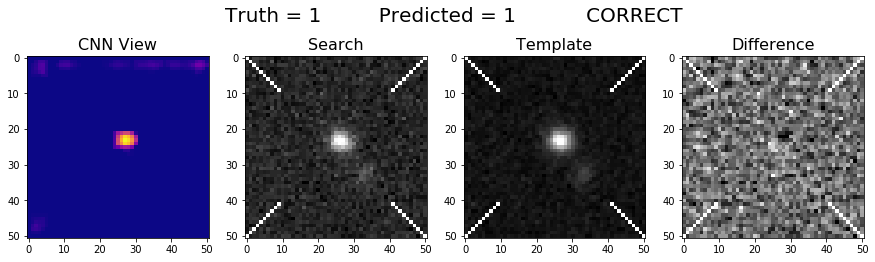

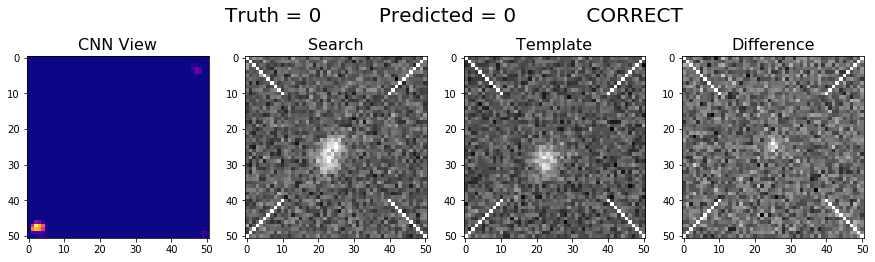

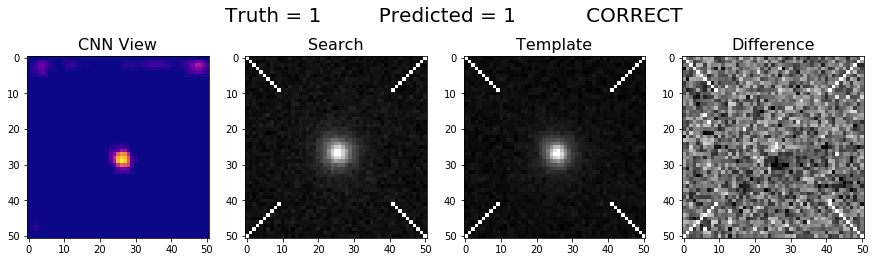

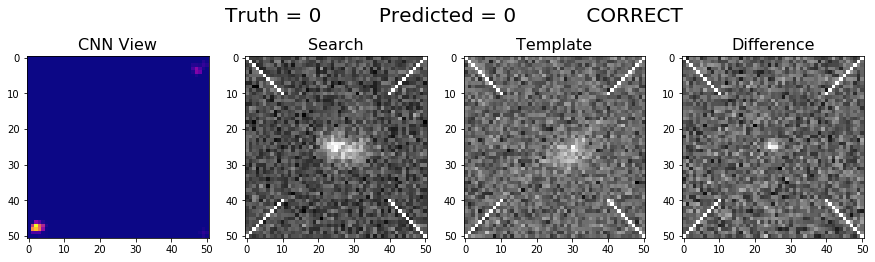

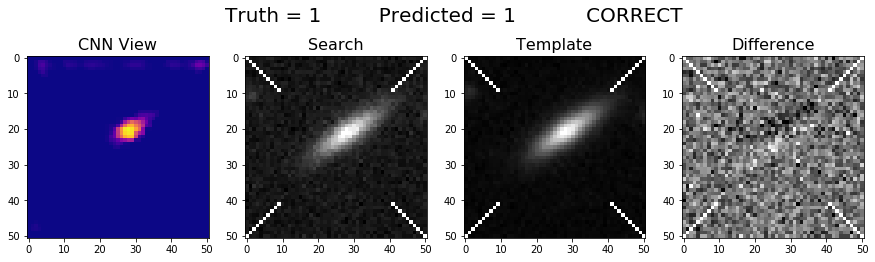

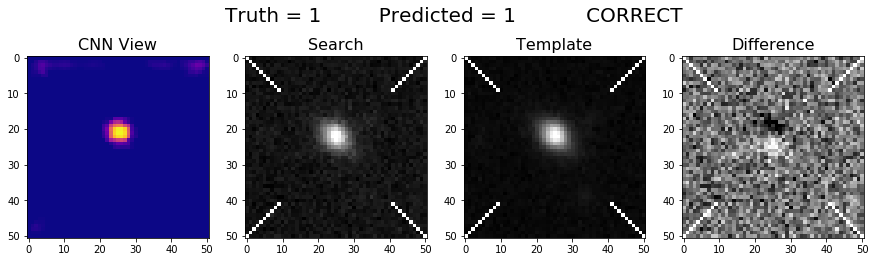

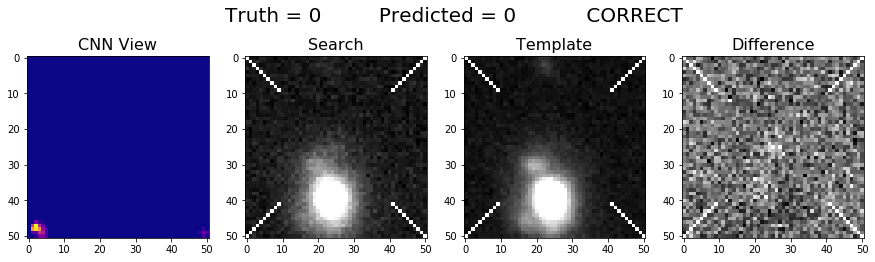

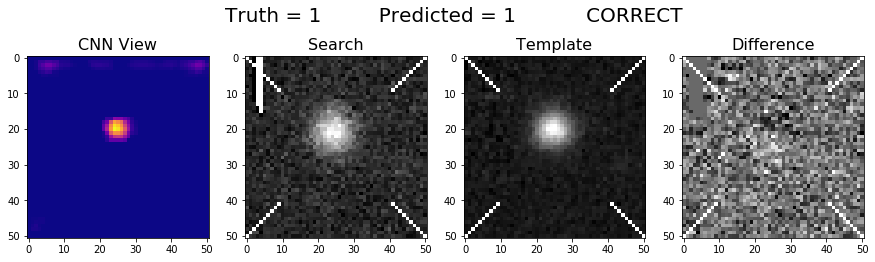

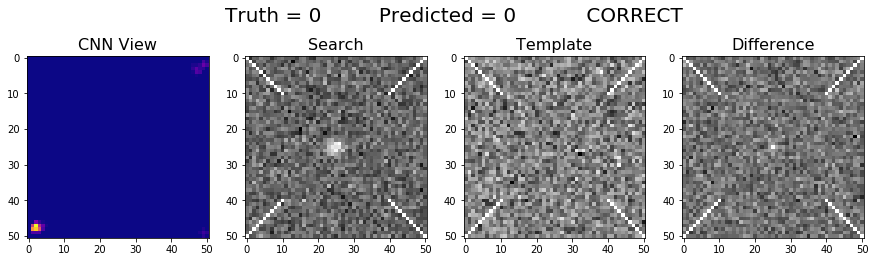

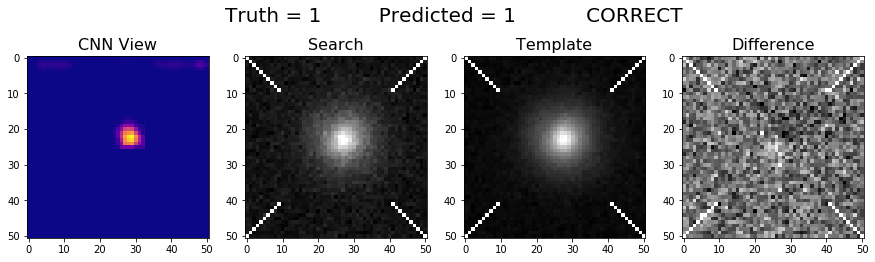

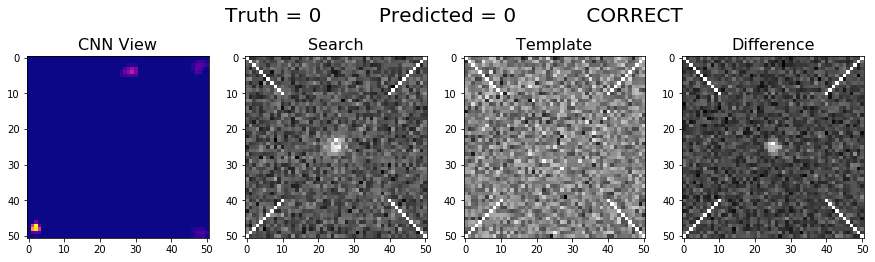

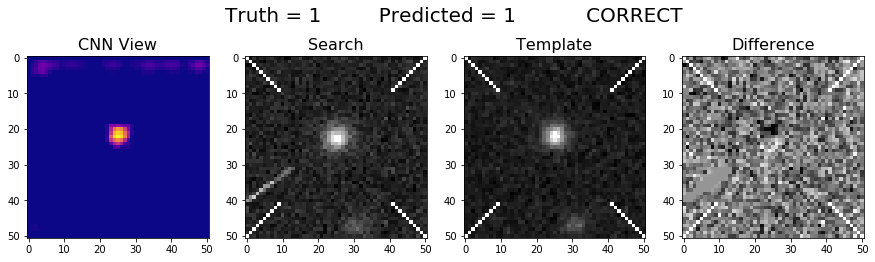

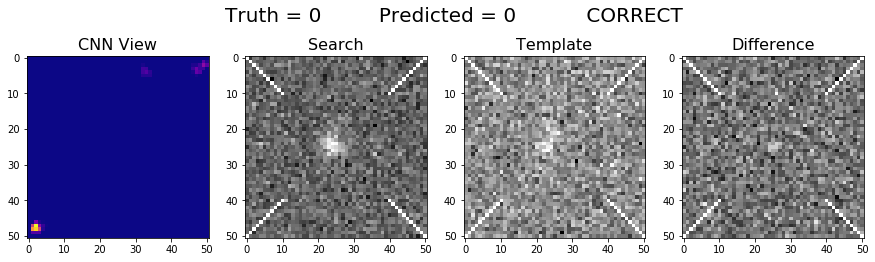

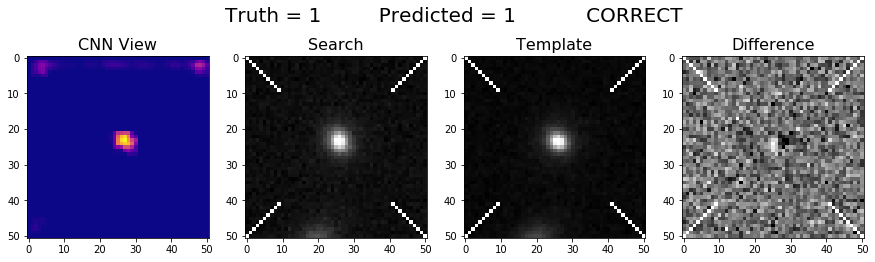

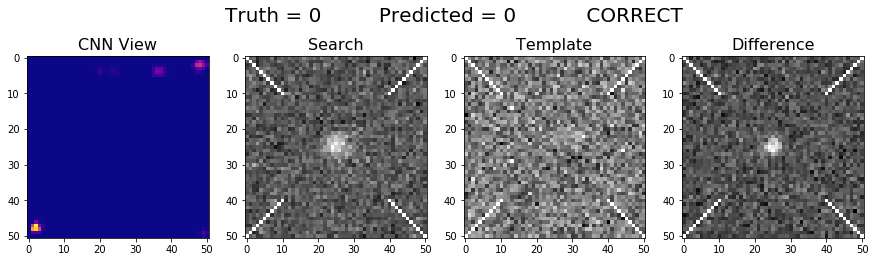

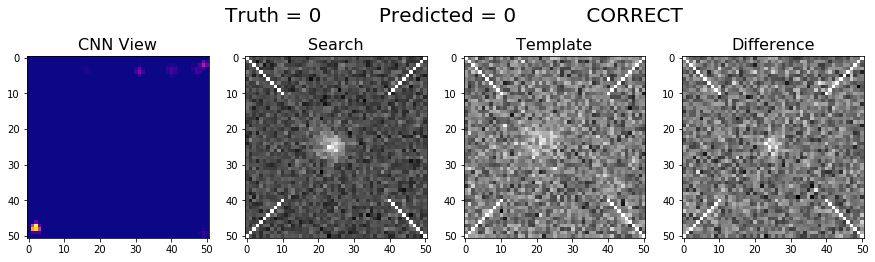

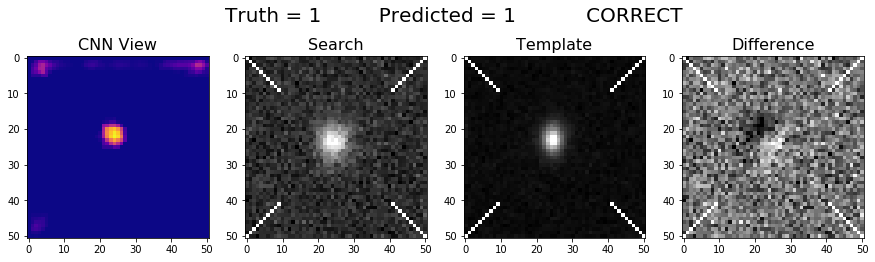

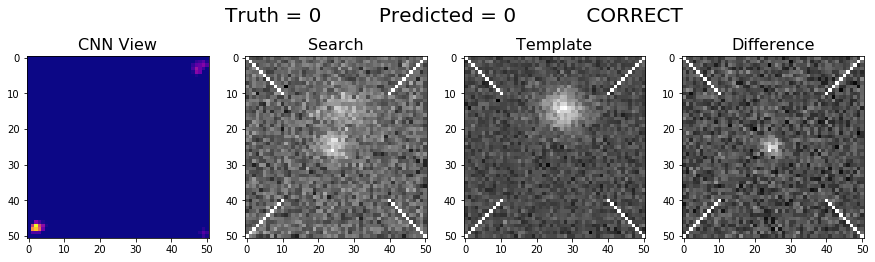

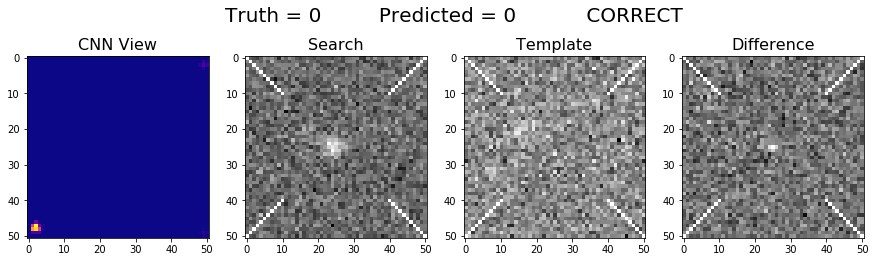

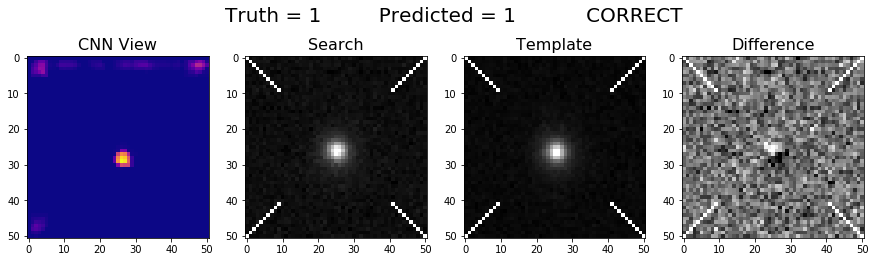

In [25]:
batch = next(iter(train_dataloader))
calculate_heatmap(cnn, batch)

In [39]:
marginal_dataset = ArtifactDataset(images_1, y_1, transform=ToTensor())
marginal_dataloader = DataLoader(marginal_dataset, batch_size=20, shuffle=True, num_workers=4)

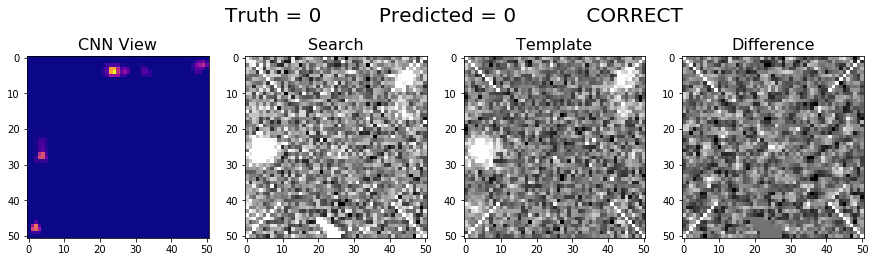

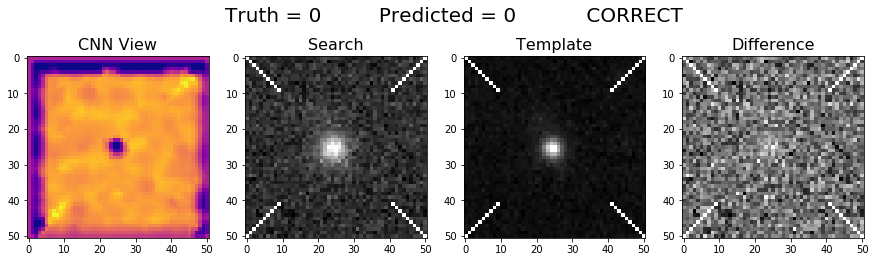

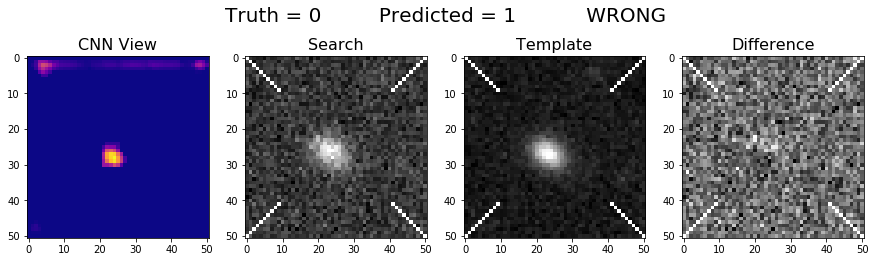

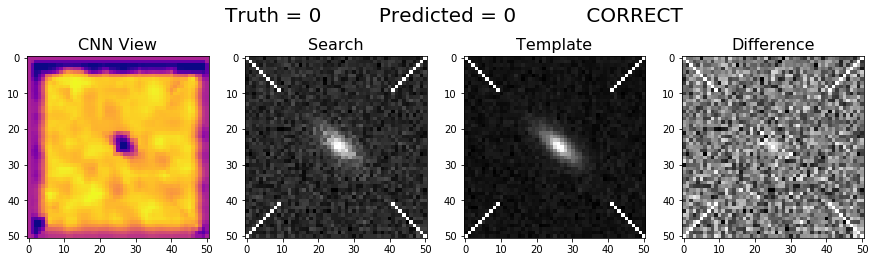

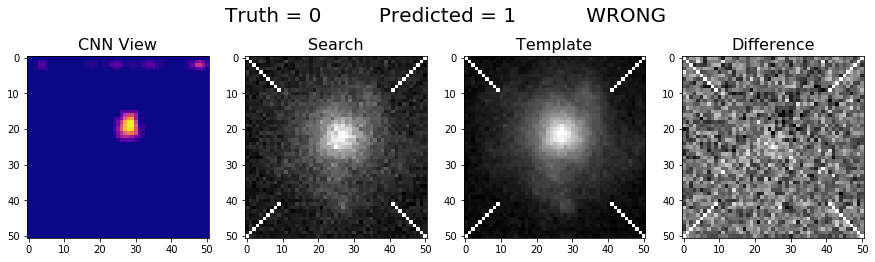

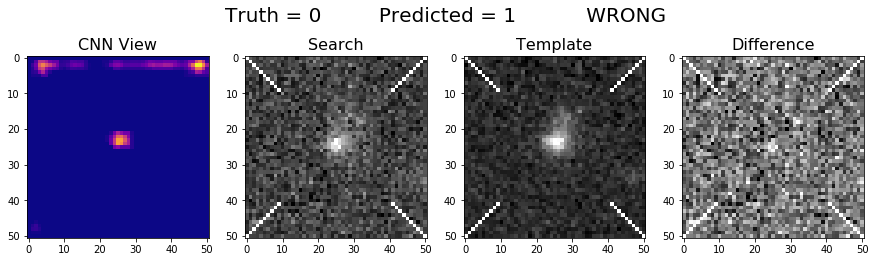

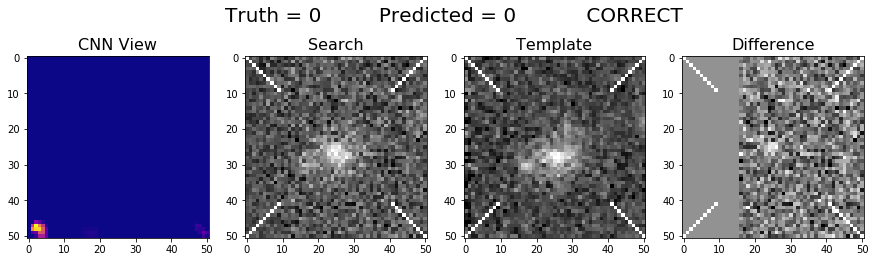

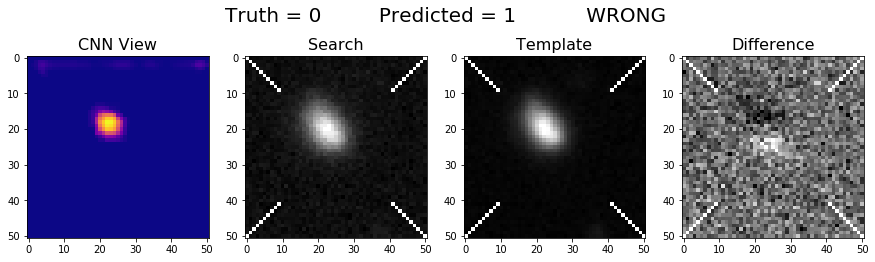

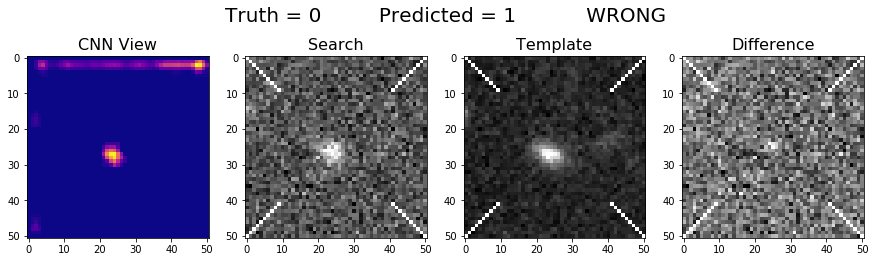

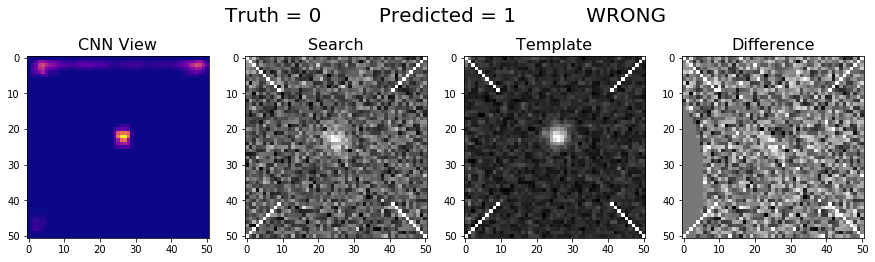

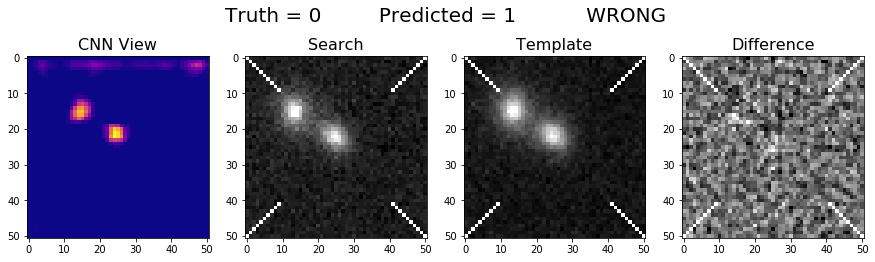

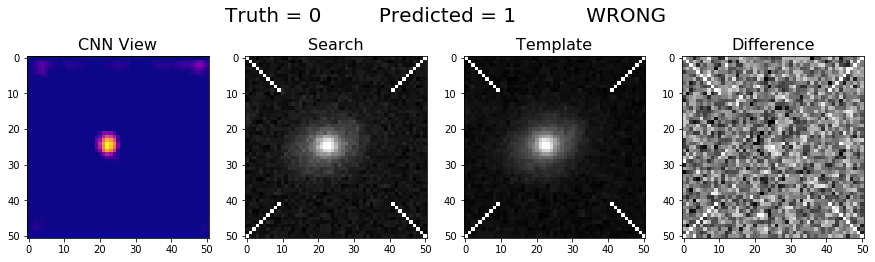

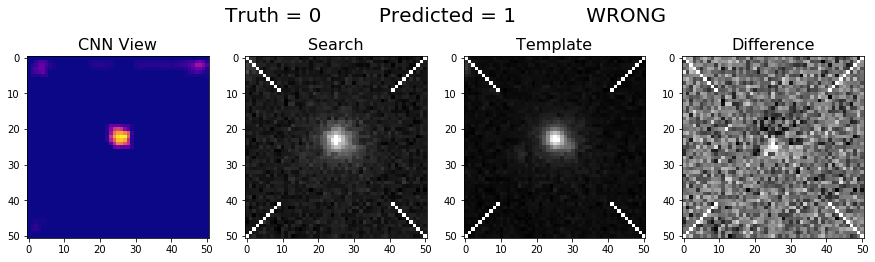

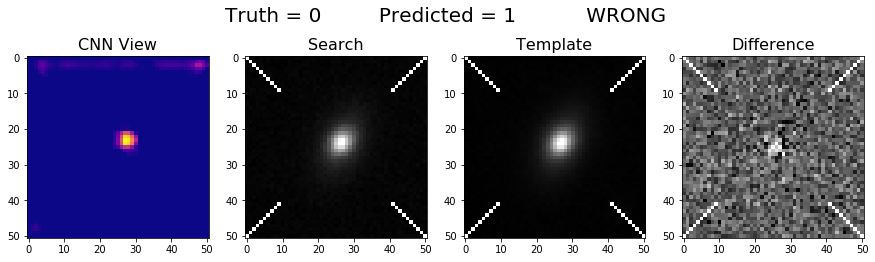

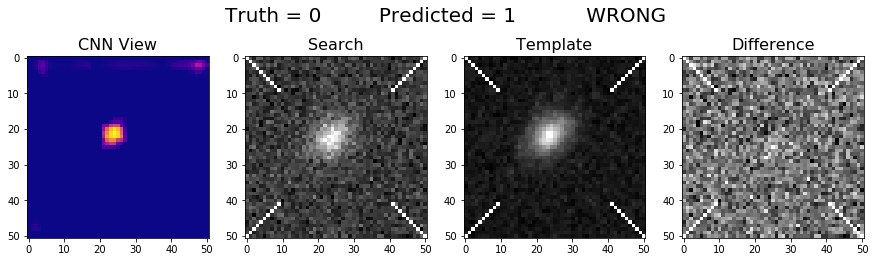

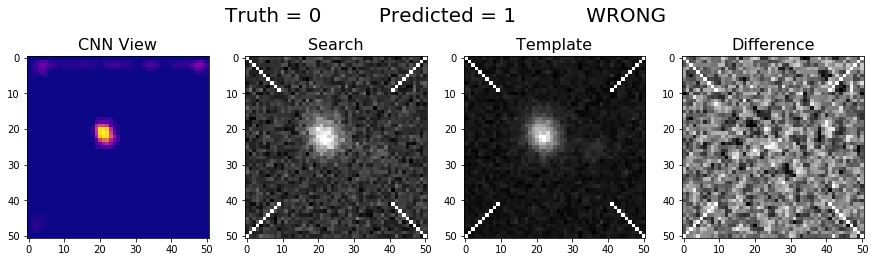

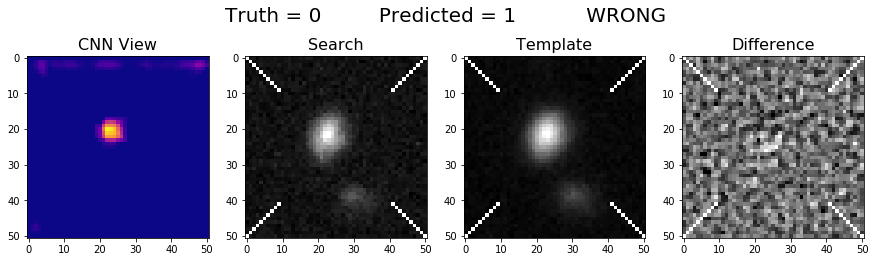

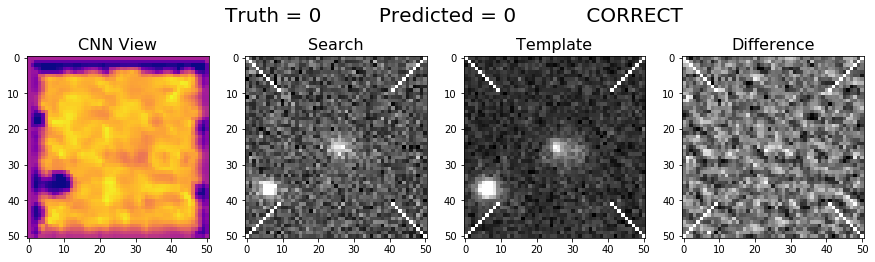

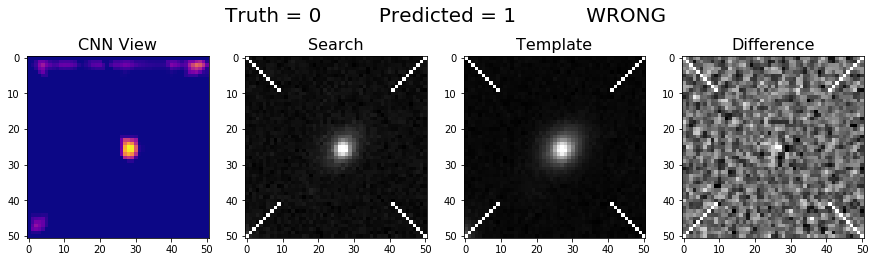

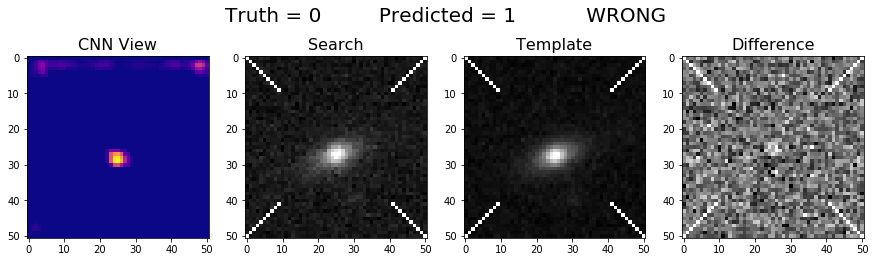

In [40]:
batch = next(iter(marginal_dataloader))
calculate_heatmap(cnn, batch)

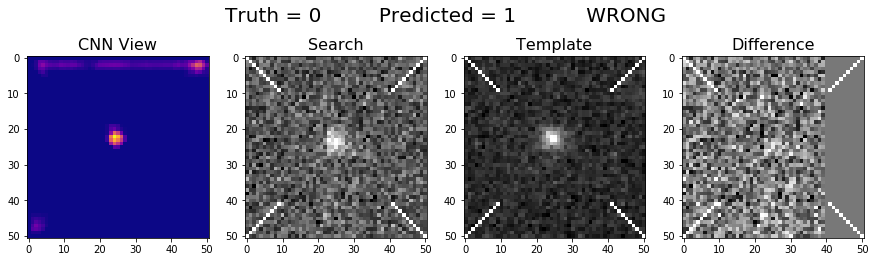

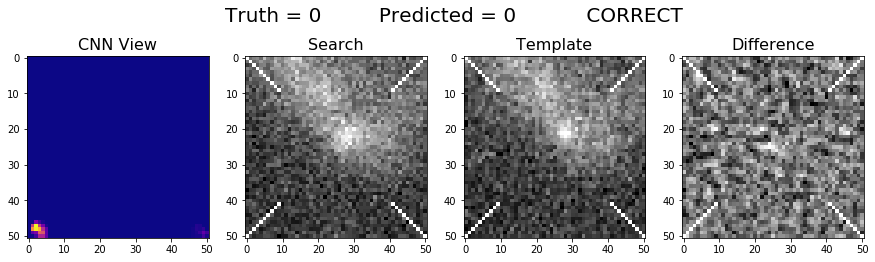

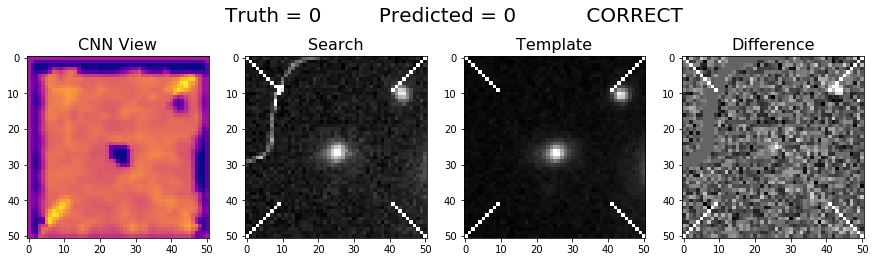

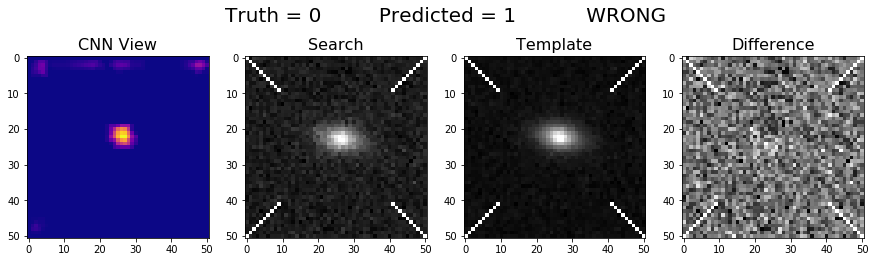

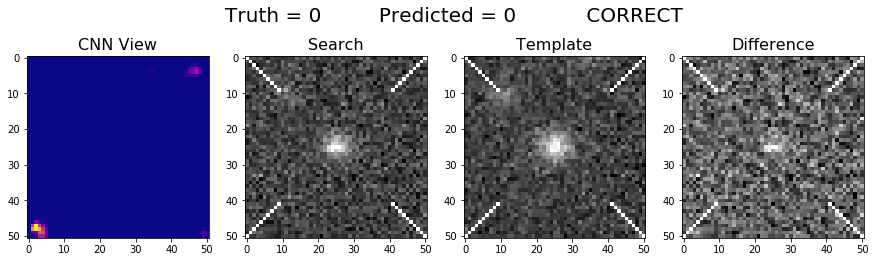

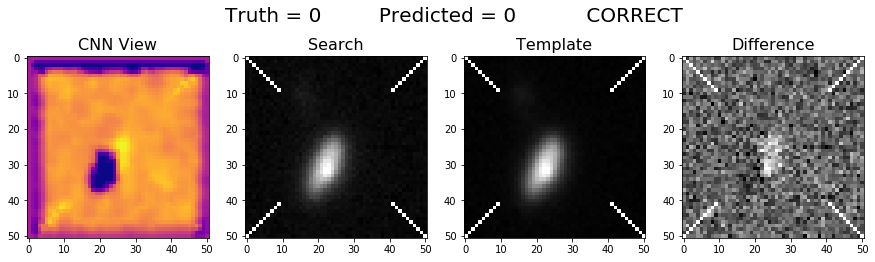

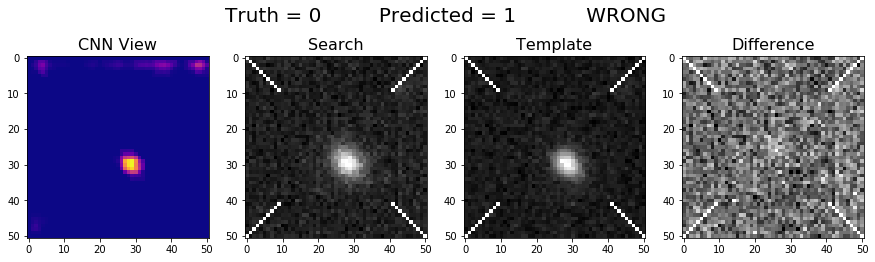

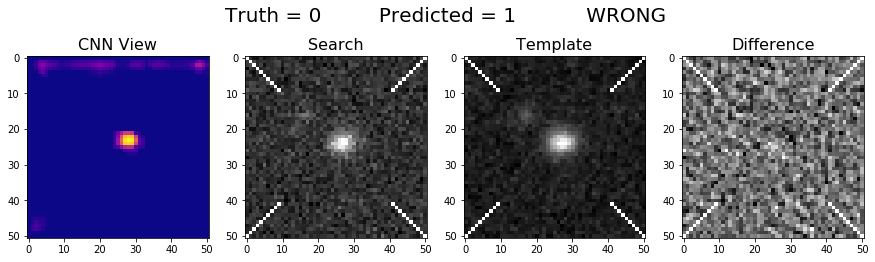

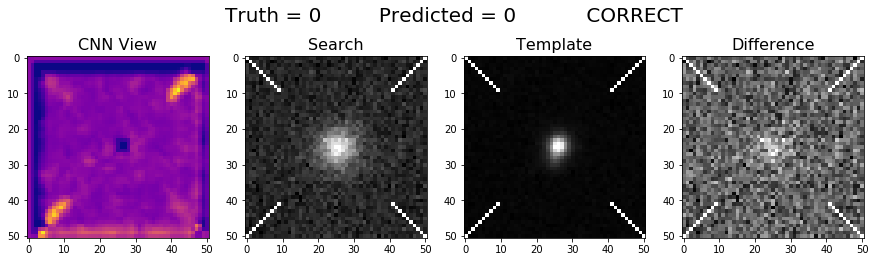

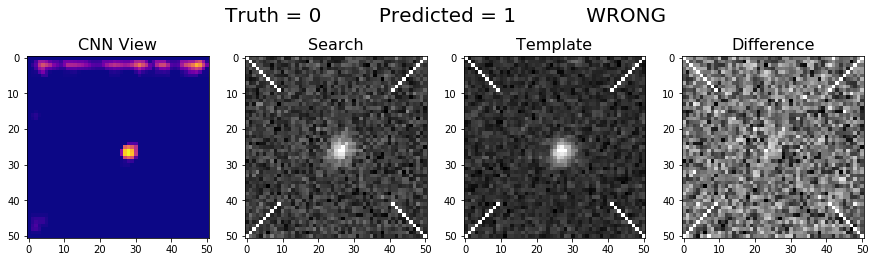

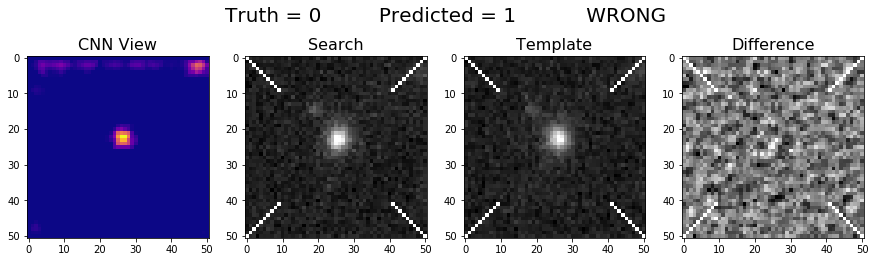

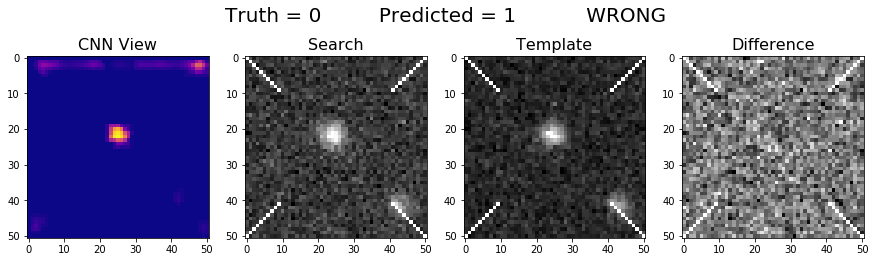

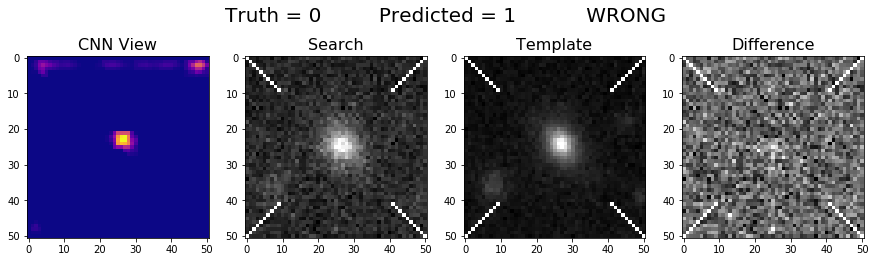

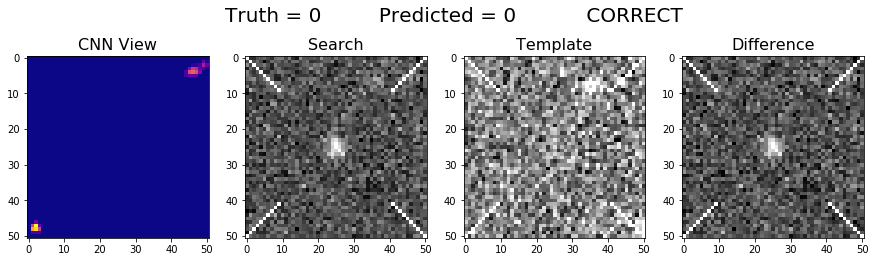

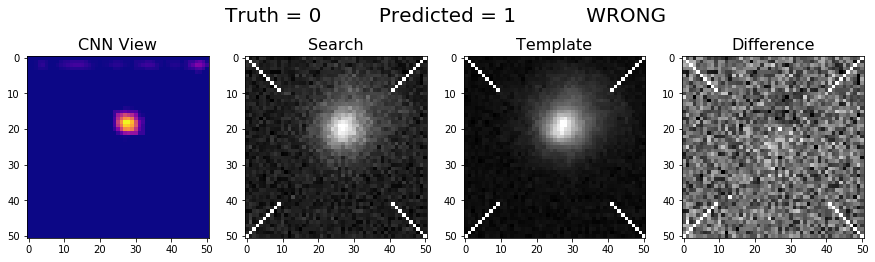

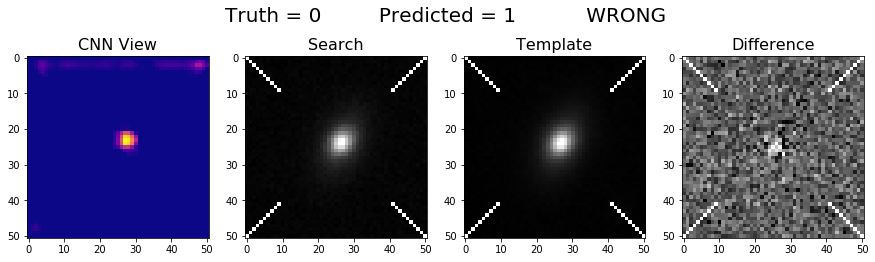

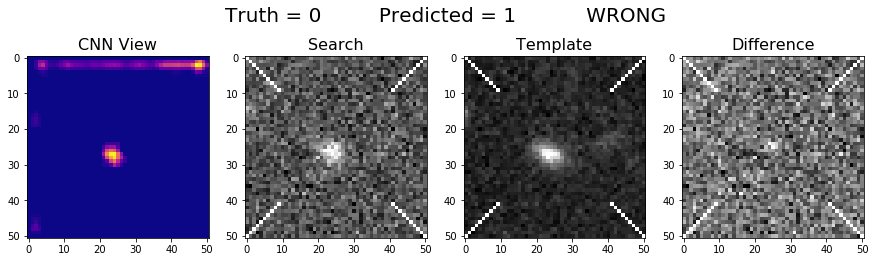

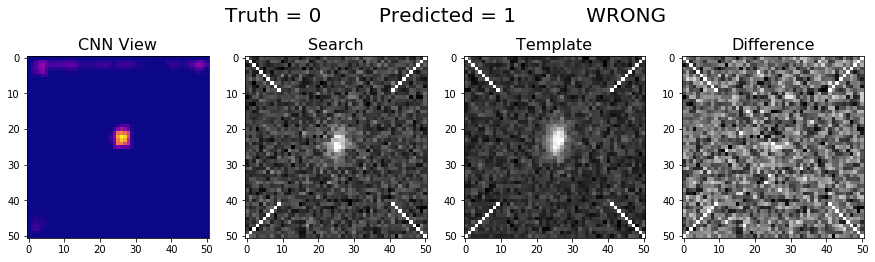

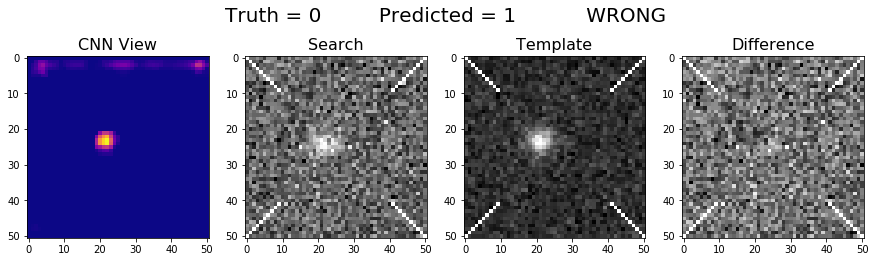

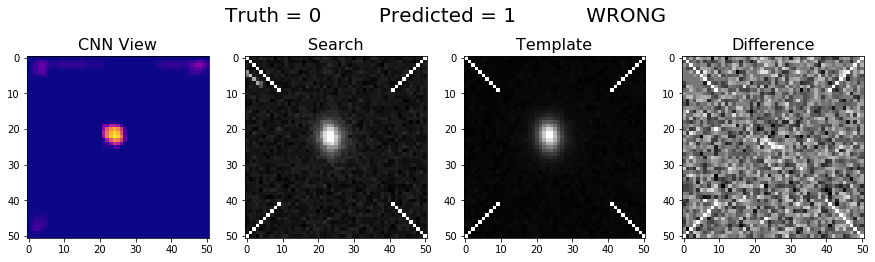

In [41]:
batch = next(iter(marginal_dataloader))
calculate_heatmap(cnn, batch)